# HW №6 "RNA-seq data analysis"

### Teacher: Mikhail Kleimenov, Bioinformatician, BostonGene <br>e-mail: mikhail.kleimenov@bostongene.com <br>Telegram https://t.me/mike_kleimenov

## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.robust.scale import mad
import seaborn as sns
from pathlib import Path
%matplotlib inline
sns.set_style('ticks')

## Introduction

In the assignment you will use data on gene expression and annotation of samples with cancer originated in Adrenal glands. Data were obtained from 6 different projects (7 cohorts). The goal is to explore the data, combine datasets in metacohort, harmonise it, and perform analysis with clustering data into four Adrenocortical Carcinoma (ACC) expressoin subtypes using corresponding gene signatures submited in zhang et al. 2016 (doi: 10.1016/j.ccell.2016.04.002).Finally, perform survival analisys based on clustering results and predict patient survival with each subtype of adrenal cancer.


---

В задании вам будут даны экспрессии генов и аннотации пациентов с раком надпочечников (Adrenal glands) из 7 когорт (6 проектов). Задача состоит в том чтобы исследовать экпрессионные данные и аннотацию, объеденить эти когорты в метакогорту, гармонизировать ее и сделать кластерный анализ - выделить экспрессионные подтипы на основе генных сигнатур, которые опубликованны в zhang et al. 2016 (doi: 10.1016/j.ccell.2016.04.002). На основе полученных кластеров посторить кривые Каплана-Майера и предсказать выживаемость пациентов с разными подтипами рака надпочесников.

## Description of some columns in annotation
<br><b>Ki67</b> - The prolifiration score based on Ki67 protein. The expression of Ki67 is strongly associated with tumor cell proliferation and growth, and is widely used in routine pathological investigation as a proliferation marker. The nuclear protein Ki67 (pKi67) is an established prognostic and predictive indicator for the assessment of biopsies from patients with cancer.<br>
<b>Weiss_score</b> - The Weiss score is prognostic factor for tumors of the adrenal cortex. <br>
<b>Purity</b> - a fraction of tumor tissue in a bulk sample. There are fractions of tumor tissue and normal tissue in each bulk sample.<br>
<b>Ploidy</b> - an average ploidy of all chromosomes over genome.

## Task №1 (0 points)
Read gene expression data and sample annotation (there is nothing special to do in this task, just run cells below).

---

Прочитайте экспрессионные данные и аннтацию (тут ничего самим делать не надо просто запустите ячейки)

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials # Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# reading expressions

datasets_drive_id = {
'GSE33371' : '1lBf74e_SLGIfrmmDWkO2DJAQlqiaJojv',    # GPL570 platform
'GSE19750_1' : '184cbgRbT3A__Nql6oXVlew7-UDXmFRLZ',  # GPL570 platform, batch 1
'GSE19750_2' : '1QCLliXnmcava4M37n9ZtMLJIbxZ8cxUr',  # GPL570 platform, batch 2
'GSE90713' : '1zVNq6_HJyjvzA4RI9wJytcY16jOJiLVo',    # GPL15207 platform
'ACC_TCGA' : '1YgGHY83A_wdx5123zVQOeLdtGbNBoQB3',    # RNA-seq, classic PolyA RNA enreachment protocol
'GSE76019' : '18MeT_SeVR649851m1XlfNLS7gOC6dwz4',    # GPL13158 platform
'PMC9066577' : '1jToWuYq1sgHeLHoDqPnH8ibURnA9Uns6'   # RNA-seq, 3MACE, subtype of PolyA rna enreachment protocol
}

datasets = datasets_drive_id.keys()
expression_file_names = {ds:'{}_expr.tsv'.format(ds) for ds in datasets}

expressions = dict()
for key, value in datasets_drive_id.items():
  downloaded = drive.CreateFile({'id' : value})
  downloaded.GetContentFile(expression_file_names[key])
  expressions[key] = pd.read_csv(expression_file_names[key], index_col = 0,sep='\t').T

# reading annotation

annotation_drive_id = '1zukJtDDm8XGRgv-dayr_Log3m65sYi2a'
annotation_file_name = 'annotation.csv'

downloaded = drive.CreateFile({'id' : annotation_drive_id})
downloaded.GetContentFile(annotation_file_name)
annotation = pd.read_csv(annotation_file_name, index_col = 0)

## Task №2 (0.5 point)

Explore the annotation. Briefly describe the data (columns) that are presented in the annotation. What diagnoses are represented in the annotation? Provide a short description of each unique item in diagnosis column. How many patients with each diagnosis are listed in the annotation? Patients with what stage of cancer are the most in the annotation? Plot purity distibution ('Purity' column).

---
Исследуйте аннотацию. В общих словах опишите какие данные там представленны. Пациенты с какими диагнозами собраны в этих когортах? Сколько пациентов с каждым из диагнозов? Пациентов в какой стадии рака больше всего? Постройте гистограмму распределения Purity.


In [4]:
annotation.head()

,Patient,type,Cohort,Diagnosis,Gender,Age,beta_catenin_status,Clinical_characteristics,Stage,Weiss_score,...,OS_FLAG,PFS,PFS_FLAG,DFS,DFS_FLAG,ploidy,purity,Resection_status,Ki67,Sample_store_method
Sample,,,,,,,,,,,,,,,,,,,,,
GSM825367,Normal Adrenal Cortex 006 [NC],RNA,GSE33371,Normal,F,71,unknown,Adrenalectomy for metastatic lung carcinoma,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825368,Normal Adrenal Cortex 063 [NC],RNA,GSE33371,Normal,F,58,unknown,Adrenalectomy for ACA; Conn's syndrome,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825369,Normal Adrenal Cortex 069 [NC],RNA,GSE33371,Normal,M,71,unknown,Adrenalectomy for renal cell carcinoma,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825370,Normal Adrenal Cortex 076 [NC],RNA,GSE33371,Normal,M,44,unknown,Adrenalectomy for ACA; Conn's syndrome,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825371,Normal Adrenal Cortex 083 [NC],RNA,GSE33371,Normal,F,32,unknown,Adrenalectomy for ACA,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В анотации представлены данные по 424 образцам коры надпочечников. Характеристики представлены в 31 колонке. В этих колонках представлена общая информация об образце (код пациента, номер когорты, диагноз, пол пациента, возраст пациента и т.д.); различные биомаркеры (секреция гормонов: андрогенов, эстрогена, алдостерона, кортизола, beta_catenin_status); клинические характеристики (Clinical_characteristics, Stage, Resection_status, Weiss_score); различные способы оценки выживаемости (OS, PFS, DFS); а также харакетристики самой опухоли (ploidy, Ki_67).

In [6]:
annotation.shape

(424, 31)

In [5]:
annotation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, GSM825367 to ACT-131
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient                   424 non-null    object 
 1   type                      209 non-null    object 
 2   Cohort                    424 non-null    object 
 3   Diagnosis                 424 non-null    object 
 4   Gender                    327 non-null    object 
 5   Age                       327 non-null    object 
 6   beta_catenin_status       65 non-null     object 
 7   Clinical_characteristics  280 non-null    object 
 8   Stage                     356 non-null    object 
 9   Weiss_score               190 non-null    object 
 10  contact_name              209 non-null    object 
 11  contact_institute         209 non-null    object 
 12  geo_accession             209 non-null    object 
 13  platform_id               209 non-null    object 
 14  Tim

В когортах собраны пациенты со следующими диагнозами: Adrenocortical_Carcinoma (количество образцов = 335), Adrenocortical_Adenoma (количество образцов = 65), Normal (количество образцов = 19), Uncertain malignant potential ACT (количество образцов = 5)

In [17]:
annotation["Diagnosis"].value_counts()

Adrenocortical_Carcinoma             335
Adrenocortical_Adenoma                65
Normal                                19
Uncertain malignant potential ACT      5
Name: Diagnosis, dtype: int64

Больше всего пациентов со второй стадией рака.

In [ ]:
annotation["Stage"].value_counts()

II                123
I                  76
III                57
IV                 52
not applicable     32
Unknown            16
Name: Stage, dtype: int64

Text(0.5, 1.0, 'Purity distibution')

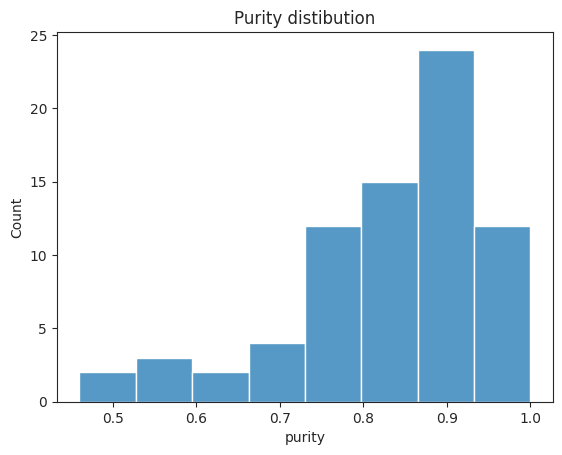

In [19]:
sns.histplot(annotation["purity"])
plt.title("Purity distibution")

## Task №3 (1 point)

Check if there is a statistically significant relationship between the patient's gender (Gender) and the Cortisol secretion level (Cortisol_secretion). The last one indicates whether the patient has an increased expression of cortisol. Take only samples for which there is information about the patient's gender ('F or 'M') and cortisol overexpression is noted ('Yes' or 'No').

---
Проверьте есть ли статистически значимая взаимосвязь между полом пациента (Gender) и переменной Cortisol_secretion, в которой отмечено замечена ли повышенная экспрессия кортизола у пациента. Для анализа берите только образцы для которых есть информация о поле пациента ('F или 'M') и повышена ли экспрессия кортизола ('Yes' или 'No')


In [20]:
from scipy.stats import chi2_contingency

In [21]:
annotation.Gender.value_counts()

F          217
M          106
Unknown      4
Name: Gender, dtype: int64

In [22]:
annotation.Cortisol_secretion.value_counts()

Unknown    225
Yes        112
No          87
Name: Cortisol_secretion, dtype: int64

In [24]:
filtered_df = annotation.loc[annotation.Gender.isin(["F","M"]) & annotation.Cortisol_secretion.isin(["Yes","No"])][["Gender","Cortisol_secretion"]]
gender_cortisol = pd.crosstab(filtered_df["Gender"], filtered_df["Cortisol_secretion"])
print(gender_cortisol)
res = chi2_contingency(gender_cortisol)
print(f"Взаимосвязь между полом пациента и секрецией кортизола статистически не значима на уровне значимости p = {res.pvalue}")

Cortisol_secretion  No  Yes
Gender                     
F                   56   86
M                   31   26
Взаимосвязь между полом пациента и секрецией кортизола статистически не значима на уровне значимости p = 0.07773452132993501


## Task №4 (1 point)

Transform each expression dataset as follows: log2(TPM+1). Exclude samples that are not in the annotation. Plot the gene expression distribution of each cohort by averaging the expressions (use sns.distplot). Print the number of genes in each cohort, the number of samples in each cohort.

---
Прологарифмируйте датасеты согласно формуле log2(TPM+1). Уберите образцы из датасетов с эксперссией для которые не встречаются в аннотации. Постройте распределение экспресии генов каждой из когорт усреднив экспрессии (можно использовать sns.distplot), выведите число генов в каждой когорте, число образцов в каждой когорте.


In [25]:
for key in expressions:
  log_df = np.log2(expressions[key] + 1)
  expressions[key] = log_df.loc[log_df.index.isin(annotation.index)]



<ipython-input-26-5f5349647675>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df,bins=30)


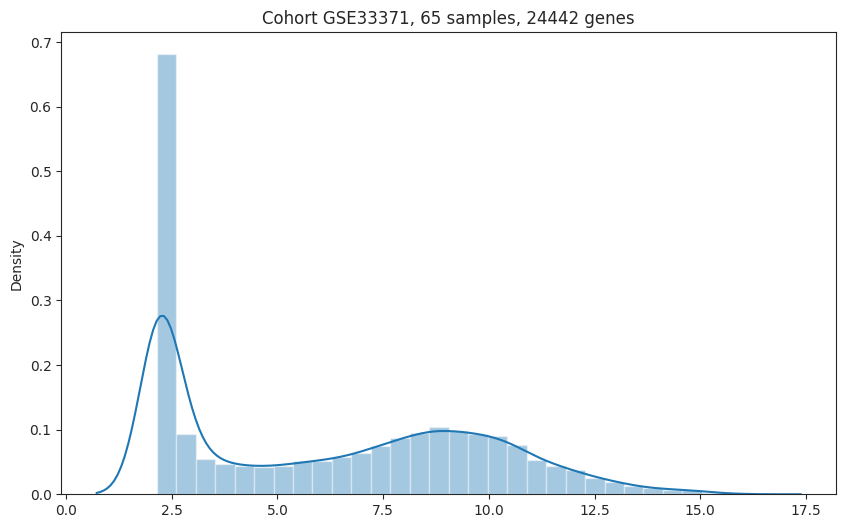

<ipython-input-26-5f5349647675>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df,bins=30)


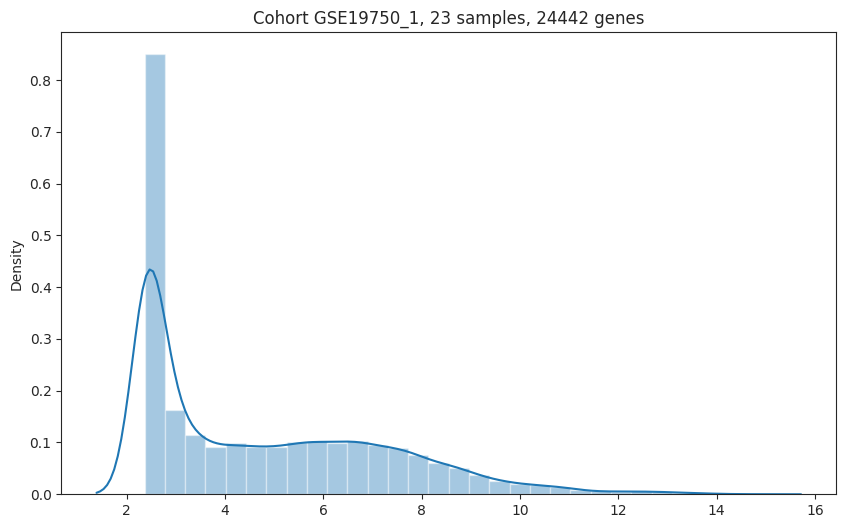

<ipython-input-26-5f5349647675>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df,bins=30)


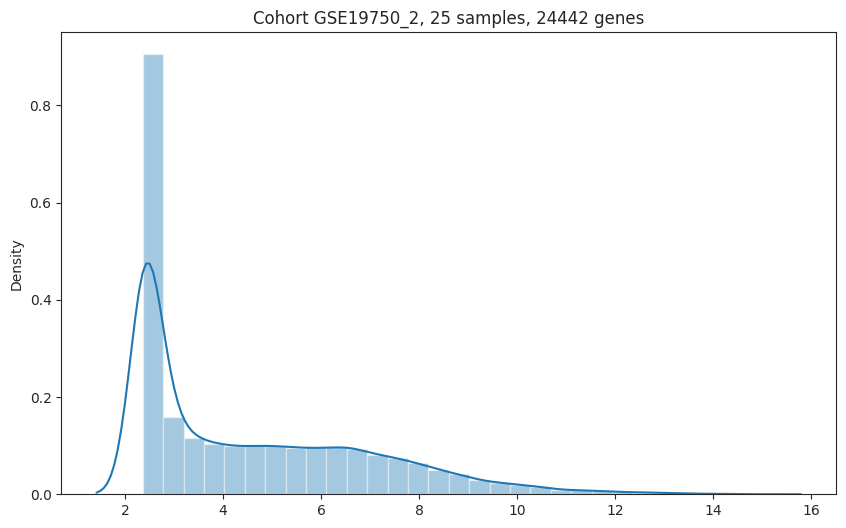

<ipython-input-26-5f5349647675>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df,bins=30)


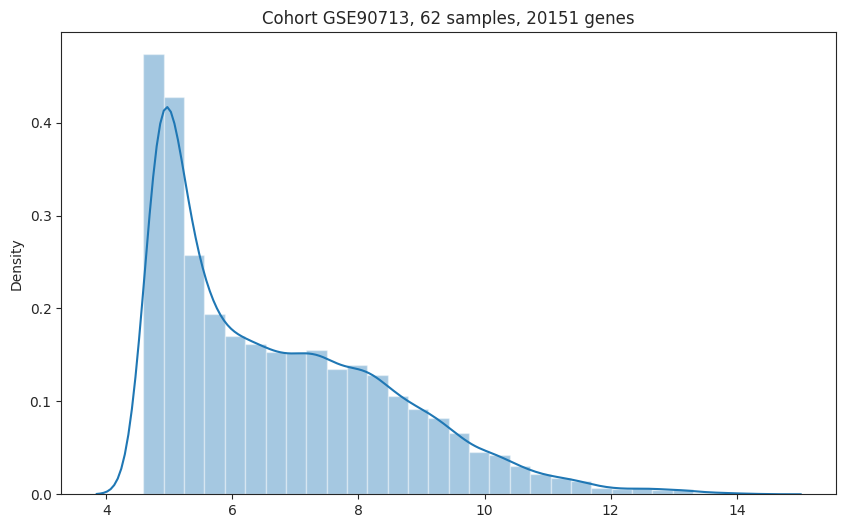

<ipython-input-26-5f5349647675>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df,bins=30)


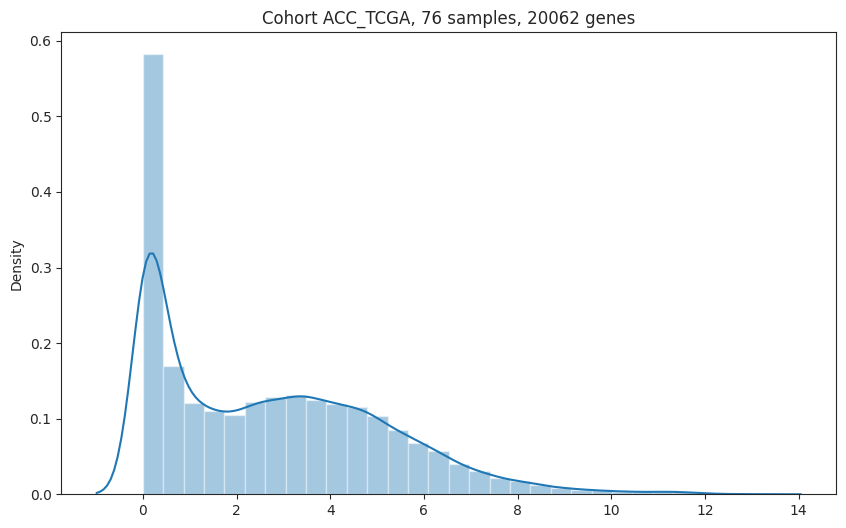

<ipython-input-26-5f5349647675>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df,bins=30)


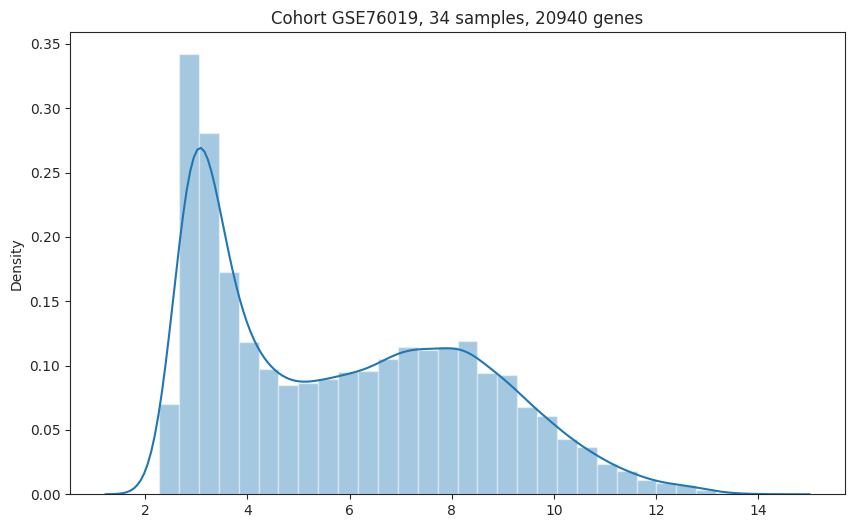

<ipython-input-26-5f5349647675>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df,bins=30)


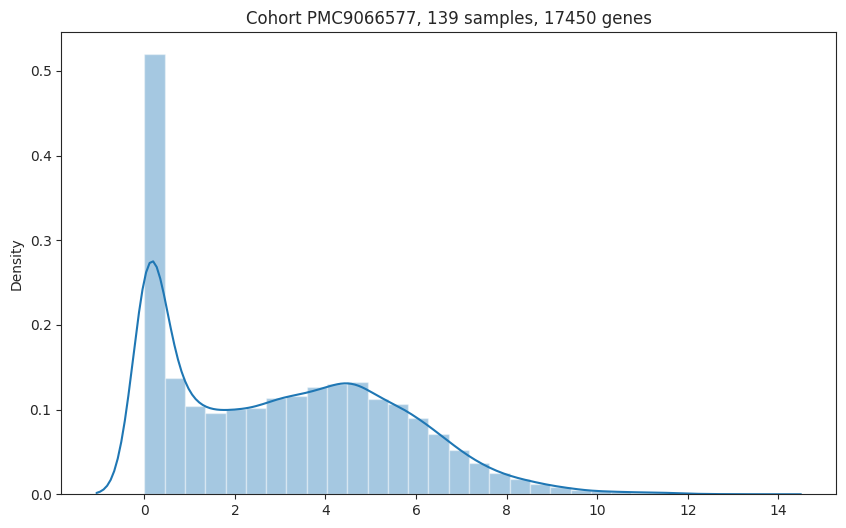

In [26]:
for key in expressions:
  temp_df = expressions[key].mean()
  plt.figure(figsize=(10,6))
  sns.distplot(temp_df,bins=30)
  plt.title(f'Cohort {key}, {expressions[key].shape[0]} samples, {expressions[key].shape[1]} genes')
  plt.xlable = 'Mean Log2(TPM+1)'
  plt.ylable = "Density"
  plt.show()



## Task №5 (0.5 point)

Take 2 ACC samples from the same cohort, find the 20 most expressed genes in both and list genes that are present in both lists (find intersection of two lists). Do the same thing for 2 ACC samples from different cohorts. Compare the number of genes in two resulting intersections and explain the difference.

---

Выберите 2 образца c диагнозом adrenocortical carcinoma из одной когорты, найдите 20 наиболее эксрессированных генов у каждого из них, и выведите список генов которые присутствуют в обоих полученных списках. Проделайте тоже самое для 2 образцов с тем же диагнозом из разных когорт. Сравние количесво генов в полученных пересечениях и предположите с чем это может быть связано.

Text(0.5, 1.0, 'Same cohort intersected genes distribution')

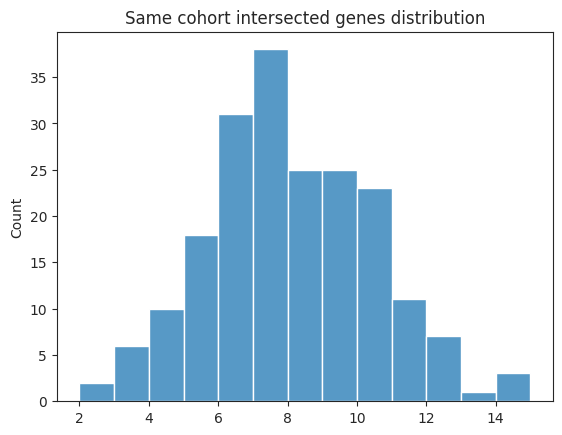

In [49]:
intersected_genes = []
for i in range(200):
  same_cohort = expressions["ACC_TCGA"].loc[annotation.Diagnosis == "Adrenocortical_Carcinoma"].sample(2)
  sample1 = same_cohort.loc[same_cohort.index[0]].nlargest(20)
  sample2 = same_cohort.loc[same_cohort.index[1]].nlargest(20)
  ig = len(set(sample1.index).intersection(sample2.index))
  intersected_genes.append(ig)

sns.histplot(intersected_genes)
plt.title("Same cohort intersected genes distribution")

Text(0.5, 1.0, 'Different cohorts intersected genes distribution')

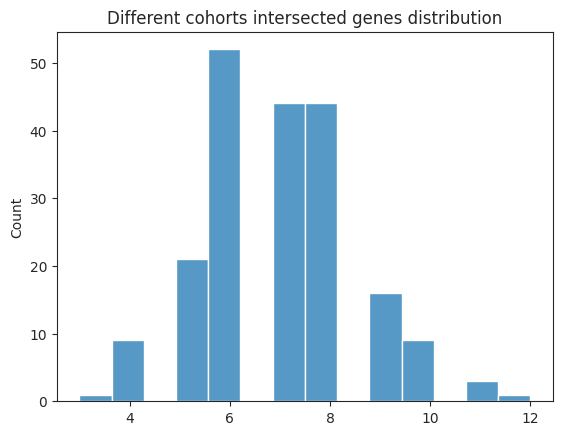

In [50]:
intersected_genes2 = []
for i in range(200):
  sample_cohort1 = expressions["GSE33371"].loc[annotation.Diagnosis == "Adrenocortical_Carcinoma"].sample(1)
  sample_cohort2 = expressions["GSE19750_2"].loc[annotation.Diagnosis == "Adrenocortical_Carcinoma"].sample(1)
  sample1 = sample_cohort1.T.nlargest(20, sample_cohort1.index[0])
  sample2 = sample_cohort2.T.nlargest(20, sample_cohort2.index[0])
  ig = len(set(sample1.index).intersection(sample2.index))
  intersected_genes2.append(ig)

sns.histplot(intersected_genes2)
plt.title("Different cohorts intersected genes distribution")

<Axes: >

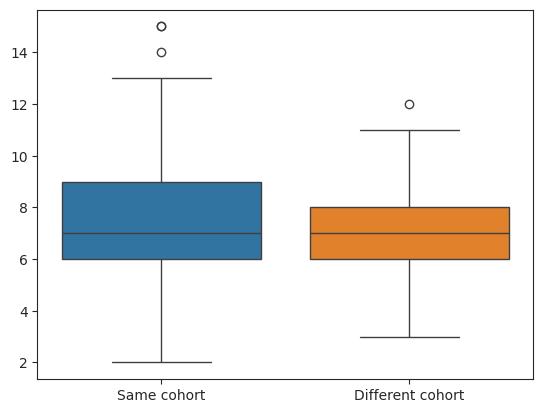

In [51]:
temp_df = pd.DataFrame({"Same cohort" : intersected_genes, "Different cohort" : intersected_genes2})
sns.boxplot(temp_df)

Когда я просто брал по два образца, то получались разные результаты количества паресекающихся генов (то в одной когорте было больше, то в двух разных, то одинакого и там и там). Если же по многу раз вычислять количество пересекеющихся генов, то становится видно, что разницы между тем, из одной ли когорты образцы, или из разных нет. Мне кажется, что так и должно быть, так как исследуются одни и теже опухоли. И, возможно, когорты были получены с использованием одинаковых методов.

## Task №6 (1 point)

Display samples from 'PMC9066577' cohort by making PCA-plot (Principal Component 1 vs Principal Component 2) with 'plot_PCA' function using gene expression as sample properties and data from annotation for coloring samples (plot_PCA 'hue' function parameter). For instance, the following colomns from annotation can be used for colouring samples:: cancer type (Diagnosis), cancer stage (Stage), histological subtype (Histological_type), Ki67 score, whether the patient has an increased level of cortisol secretion (Cortisol_secretion). Which of these columns better explains the grouping of samples on the plot?

---

Постройте PCA-plot для всей когорты 'PMC9066577' (Principal Component 1 vs Principal Component 2) с помощью функции plot_PCA, используя экспрессию генов как свойства образцов и данные из аннотации для расраски образцов в разные цвета (параметр функции plot_PCA 'hue'). Пример данных из аннотации по которым можно покрасить график: вид рака (Diagnosis), стадия рака (Stage), гистологический подтип (Histological_type), Ki67 score, повышен ли у пациента уровень секреции кортизола (Cortisol_secretion). Какие из этих параметров лучше объясняют группировку образцов на графике?

In [52]:
def plot_PCA(data, hue = None, size = (6,6), dot_size = 30):
    '''
    dependances: PCA from sklearn.decomposition and sns.scatterplot from seaborn

    Parameters
    ----------
    data: pandas.DataFrame
        a dataframe containing expression data, where rows are genes and columns are samples
    hue: a list
        an annotation data vector for coloring dots on the plot
    size: a tuple
        plot width and height
    dot_size: int
        size of the dots on the plot
    '''
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(data.T)
    pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
    plt.figure(figsize = size)
    x_label = 'PCA Component 1 explained {}% of variance'.format(round(pca.explained_variance_ratio_[0] * 100, 1))
    y_label = 'PCA Component 2 explained {}% of variance'.format(round(pca.explained_variance_ratio_[1] * 100, 1))
    fig = sns.scatterplot(data = pca_expr_df, x = 'PC1', y = 'PC2', hue = hue, s=dot_size)#, linewidth=0)
    if hue != None:
        fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    fig.set(xlabel = x_label, ylabel = y_label)
    plt.show()

In [60]:
tt = annotation.loc[annotation.Cohort == "PMC9066577"]
temp = expressions["PMC9066577"].merge(tt, left_index=True,right_index=True)


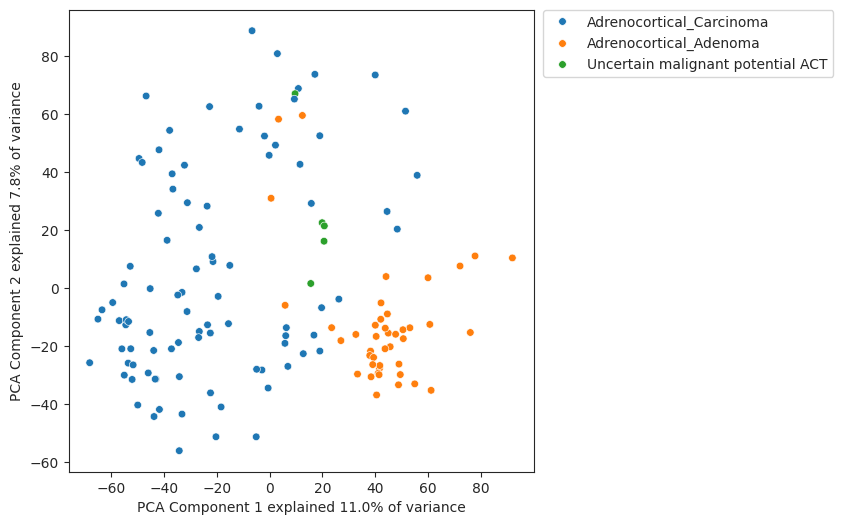

In [61]:
plot_PCA(expressions["PMC9066577"].T,hue=tt["Diagnosis"].tolist())

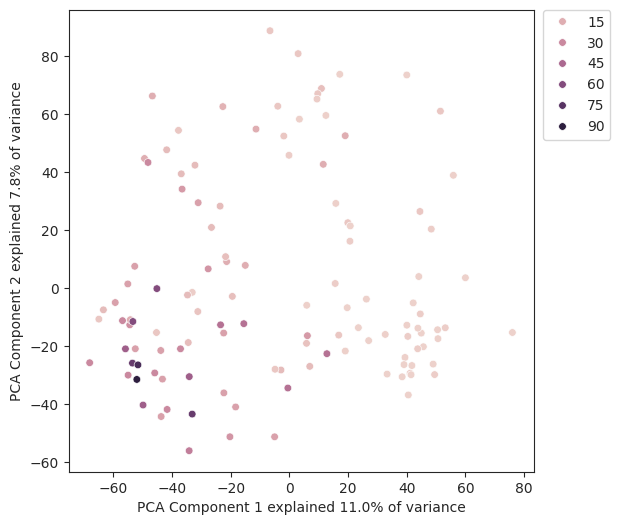

In [62]:
plot_PCA(temp.iloc[:,0:-31].T,hue=temp["Ki67"].tolist())

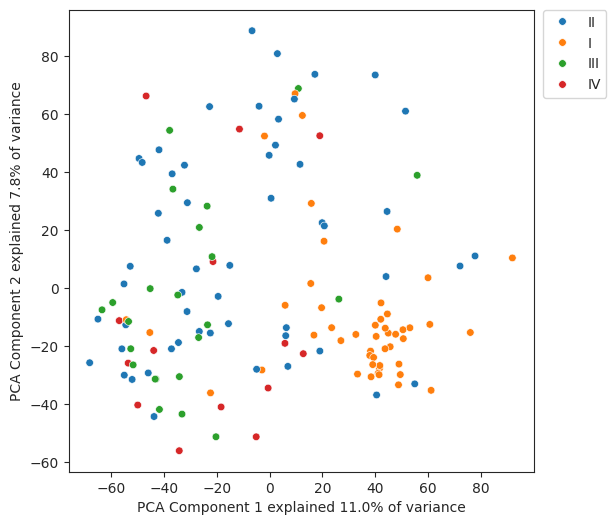

In [63]:
plot_PCA(temp.iloc[:,0:-31].T,hue=temp["Stage"].tolist())

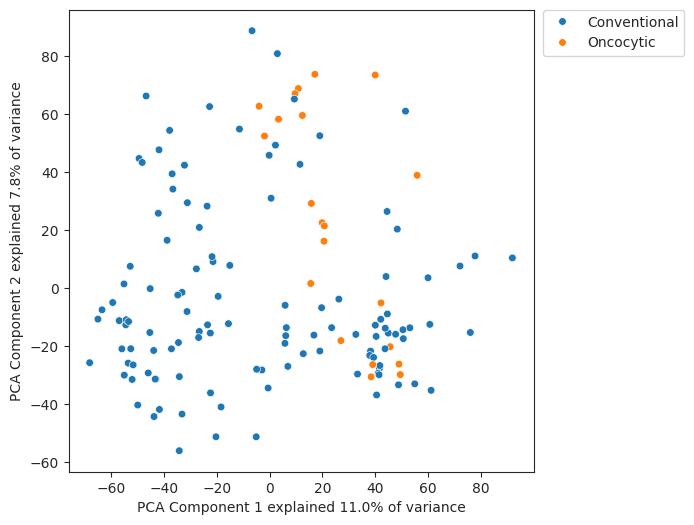

In [64]:
plot_PCA(temp.iloc[:,0:-31].T,hue=temp["Histological_type"].tolist())

Лучше всего группироваку образцов объясняет Диагноз. С использованием Ki67 тоже можно выделить какие-то группы, но границу между ними провести намного тяжелее. Интересно, что многие образцы с диагнозом Adrenocortical adenoma имеют первую стадию заболевания.

## Task №7 (1 point)

Join all expression data into one dataframe. Keep only samples that are in the annotation, and exclude genes that filled with NA values. Print the number of resulting genes and samples. Make a PCA plot on joint data with sample coloring using the Diagnosis and Cohort columns from the annotation. Briefly describe the resultion plot and explain why the samples are grouped this way.

---
Объедените данные экспрессий в один датафрейм (не забудьте удалить гены в которых есть значения NA и убрать образцы которых нет в анотации). Сколько всего генов по которым есть данные во всех образцам? Постройте PCA-plot и покрасьте образцы с помощью колонок Diagnosis и Cohort из аннотации. Опишите групировку образцов на графиках и объясните.


In [65]:
exp_allcohorts = pd.DataFrame()
for key, value in expressions.items():
  exp_allcohorts = pd.concat([exp_allcohorts,value])


In [66]:
filtered_all_exp = exp_allcohorts.loc[exp_allcohorts.index.isin(annotation.index)].dropna(axis=1)

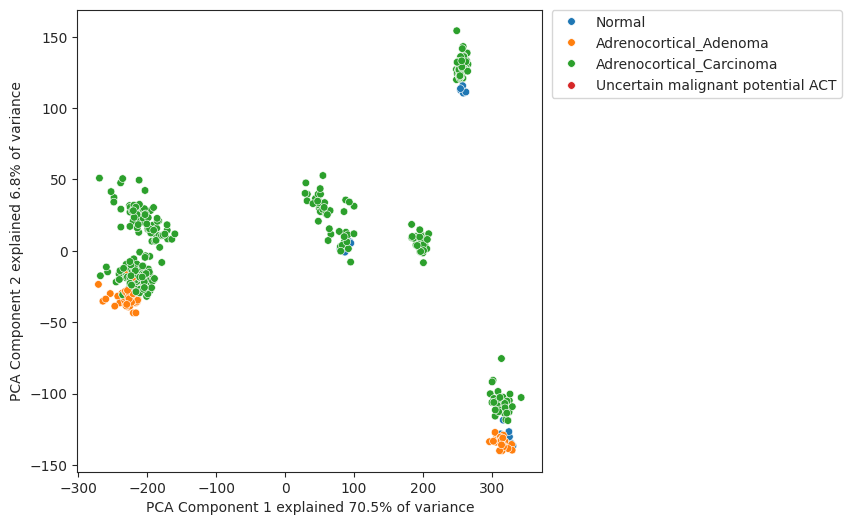

In [67]:
plot_PCA(filtered_all_exp.T,hue=annotation["Diagnosis"].tolist())

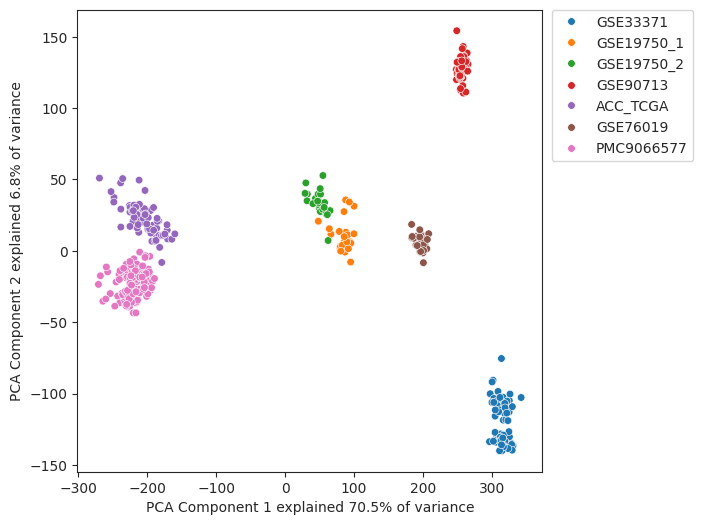

In [68]:
plot_PCA(filtered_all_exp.T,hue=annotation["Cohort"].tolist())

Видно, что образцы группируются по когортам, но не по диагнозам. Это признак пличия батч-эффекта.

## Task №8 (1 point)
Save the expressions of all Adrenocortical carcinoma samples in a separate data frame. Calculate gene signature scores using the cacl_sign_scores function (the list of genes for each signature will be stored in the expr_signs variable after running the cell below). Transform the scores using the median_scaling function (over scores, not over samples) and plot the PCA (PC1 vs PC2) using the scores as sample properties.

---

Сохраните в отдельный датафрейм экспрессию всех образов с диагнозом Adrenocortical carcinoma. Используя функцию cacl_sign_scores, рассчитайте скоры экспрессионных сигнатур для кажлого образца (после запуска ячеек ниже, сигнатуры будут сохранены в переменной expr_signs). Отшкалируйте данные используя функцию median_scaling (по скорам, не по образцам), постройте PCA плот, используя расчитанные скоры как свойства образцов.

In [69]:
signatures_file = 'TCGA_expr_profiles.csv'
signatures_drive_id = '195vZN8IFsZ9jDsgeuool9NHI6T_axxb9'

downloaded = drive.CreateFile({'id': signatures_drive_id})
downloaded.GetContentFile(signatures_file)
sign_data = pd.read_csv(signatures_file, sep = ';', skiprows=7)

tcga_nmf_clusters = {4 : 'steroid-phenotype-low+proliferation',
1 : 'steroid-phenotype-high+proliferation',
2 : 'steroid-phenotype-low',
3 : 'steroid-phenotype-high'}

expr_signs = dict()
for f in np.unique(sign_data.loc[:,'NMF-factor']):
    expr_signs[tcga_nmf_clusters[f]] = list(sign_data.loc[sign_data['NMF-factor'] == f,:].GeneSymbol)

In [70]:
sign_data

,GeneSymbol,GeneID,NMF-factor,tStat,pValue,tStat.1,pValue.1,tStat.2,pValue.2,tStat.3,pValue.3
0,ACAT2,39,1,0.37,0.716000,4.39,0.000036,-4.07,1.140000e-04,-0.83,0.412000
1,LPA,4018,1,0.88,0.381000,4.27,0.000057,-4.35,4.120000e-05,-1.29,0.203000
2,SPRR2B,6701,1,-1.52,0.132000,4.99,0.000004,-2.65,9.730000e-03,-0.19,0.848000
3,HSD3B2,3284,1,1.92,0.058300,4.52,0.000022,-5.48,5.230000e-07,-2.21,0.029900
4,AQP2,359,1,0.41,0.685000,3.69,0.000415,-3.99,1.500000e-04,0.03,0.978000
...,...,...,...,...,...,...,...,...,...,...,...
146,TNFSF12-TNFSF13,407977,4,-2.27,0.025800,-0.71,0.477000,1.80,7.630000e-02,2.40,0.018900
147,UBD,10537,4,-3.77,0.000326,-0.64,0.527000,2.20,3.060000e-02,4.50,0.000024
148,CPXM1,56265,4,-1.91,0.059900,-1.52,0.132000,1.75,8.480000e-02,3.58,0.000600
149,CD3D,915,4,-3.59,0.000583,-2.29,0.024700,4.01,1.410000e-04,4.07,0.000115


In [71]:
for key, value in expr_signs.items():
  print(key, len(value))

steroid-phenotype-high+proliferation 36
steroid-phenotype-low 39
steroid-phenotype-high 38
steroid-phenotype-low+proliferation 38


In [72]:
def cacl_sign_scores(data, gene_sets, rank_method='max'):
    '''
    :param data: pd.DataFrame, DataFrame with samples in columns and genes in rows
    :param gene_sets: dict, with signature names in keys and gene lists in values
    :param rank_method: str, default 'max', how to rank the group of records that have the same value,
        type in cell "??pd.DataFrame.rank" for detailes, 'method' parameter
    '''
    processes = pd.DataFrame(0, index = expr_signs.keys(), columns = data.columns)
    data_ranked = data.rank(method=rank_method, na_option='bottom')

    for gs_name in list(gene_sets.keys()):
        genes = gene_sets[gs_name]
        common_genes = list(set(genes).intersection(set(data_ranked.index)))
        if not len(common_genes):
            continue
        else:
            sranks = data_ranked.loc[common_genes,:]
            scores = (sranks**1.25).sum() / (
                sranks**0.25).sum() - (len(data_ranked.index) - len(common_genes) + 1) / 2
            processes.loc[gs_name, scores.index] = scores
    if processes.all().sum() == 0:
        print('WARNING: returning zero dataframe.')
    return processes

In [73]:
def median_scaling(df, clip=None):
    '''
    :param df : pandas.DataFrame, where rows are samples and columns are genes
    :param clip: float, default 'None', symmetrically clips the scaled data to the value
    =======================================================================================
    mad function from statsmodels.robust.scale - The Median Absolute Deviation along given axis of an array
    '''
    median = 1.0 * df.median()
    madv = 1.0 * mad(df)
    df_out = df.sub(median).div(madv)
    if clip is not None:
        return df_out.clip(-clip, clip)
    return df_out

In [74]:
acc_df = filtered_all_exp.loc[filtered_all_exp.index.isin(annotation.loc[annotation["Diagnosis"] == "Adrenocortical_Carcinoma"].index)]
df = cacl_sign_scores(acc_df.T,gene_sets=expr_signs)

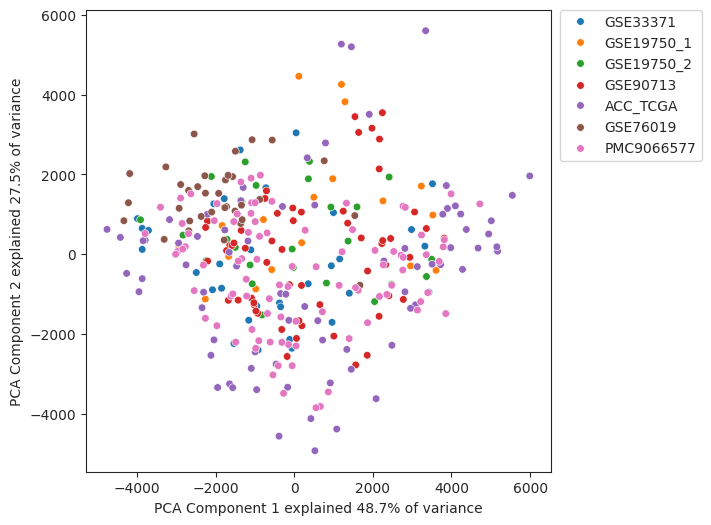

In [75]:
plot_PCA(df,hue=annotation["Cohort"].loc[annotation["Diagnosis"] == "Adrenocortical_Carcinoma"].tolist())

In [76]:
scaled_scores2 = median_scaling(df.T, clip=None)

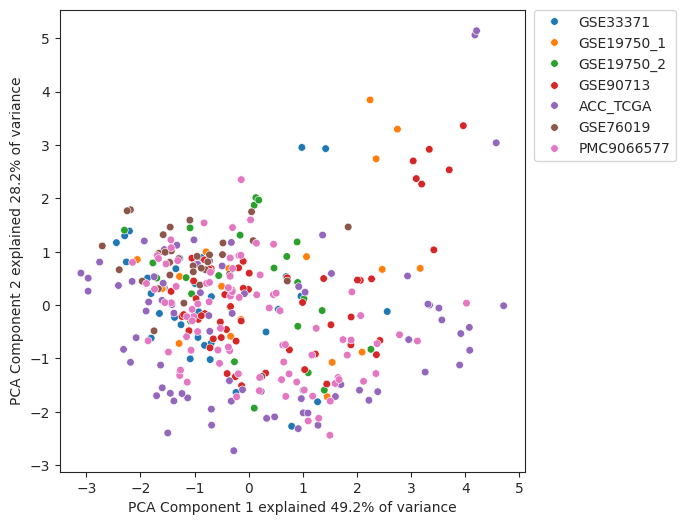

In [77]:
plot_PCA(scaled_scores2.T,hue=annotation["Cohort"].loc[annotation["Diagnosis"] == "Adrenocortical_Carcinoma"].tolist())

После этих действий образцы больше невозможно разделить на группы по когортам.

## Task №9 (2 points - 1 point for each algorithm)

Perform a cluster analysis of the dataset containig gene signatures scores using Agglomerative Clustering (Hierarchical clustering) and K-mean algorithms. Specify the number of clusters - 4 (n_clusters=4). Diaplay PCA-plot, colour samples with claster labels. <br>

Which of these algorithms is best suited for this task? (give answer based on visual inspection). For Agglomerative Clustering, try different methods for calculating the distances between samples (linkage parameter), which method shows a better result? For K-means, run a algorithm a few times and evaluate the reproducibility of the results.

---
Проведите кластерный анализ полученного в задаче 8 датаета со скорами сигнатур, используя алгоритмы Agglomerative Clustering (Иерархическая кластеризация) и K-means, n_clusters=4.  Постройте PCA plot, используя полученную разметку образцов по класетерам для раскраски образцов.

Какой из этих алгоритмов лучше выделяет кластера (дайте ответ на основании визуальной инспекции)? Для Agglomerative Clustering попробуйте различные методы расчета растояний между образцами (параметр linkage), какой метод показывает более адекваный результат? Для K-means проведите несколько повторений и оцените воспроизводимость результатов.

---

Manuals:<br>
AgglomerativeClustering https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html<br>
K-means https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html



In [78]:
from sklearn.cluster import AgglomerativeClustering, KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


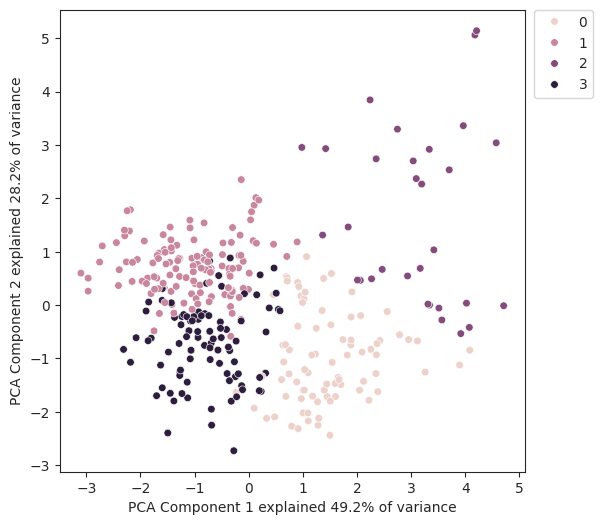

In [123]:
kmeans = KMeans(n_clusters=4).fit_predict(scaled_scores2)
plot_PCA(scaled_scores2.T,hue=kmeans.tolist())

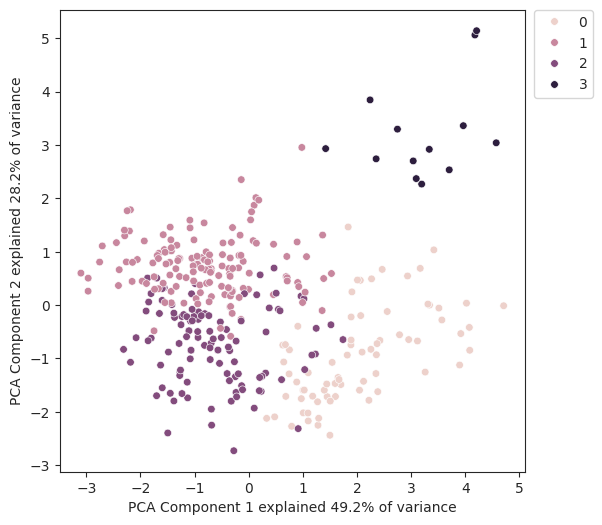

In [80]:
agc = AgglomerativeClustering(n_clusters=4,linkage="ward").fit_predict(scaled_scores2)
plot_PCA(scaled_scores2.T,hue=agc.tolist())

Kmeans лучше всего выделяет кластера и после нескольких повторений его результаты остаются устойчивыми. AgglomerativeClustering с использованием метода "ward" для расчета растояний между образцами справляется чуть хуже.

## Task №10 (2 points)

Choose one of the clustering results that you think is the best. Here, the 4 found clusters represent 4 Adrenocortical carcinoma subtypes obtained using expression data.
* Plot Kaplan-Meier curves for each of the four subtypes using the kaplanmeier package. Use the annotation columns 'OS' (number of months under observation) and 'OS_FLAG' (occurrence of event, 1 - patient decreased, 0 - patient alive), remember to remove samples with missing values (NA). How many patients are included in this survival analysis? Which subtype is associated with the worst prognosis and which one with the best?

* Each of the 4 gene signatures characterizes one of the 4 subtypes. It is expected that the belonging of a sample to a particular subtype can be determined by the largest gene signature score (steroid-phenotype-low+proliferation, steroid-phenotype-high+proliferation, steroid-phenotype-low, steroid-phenotype-high). Based on this, determine the approximate correspondence of the obtained 4 clusters and 4 subtypes of adrenal cancer and label the curves on the Kaplan-Meier plot.
---

Выберете один из результатов кластеризации, который считаете наиболее адекватным. Четыре полученных кластера в задаче 9 это четыре подтипа Adrenocortical carcinoma, выделенных на основании экспрессионного анализа.
* Посторойте кривые Каплана-Майера для пациентов каждого из четырех подтипов используя пакет kaplanmeier. Используйте колонки из аннотации 'OS' (число месяцев под наблюденим) и 'OS_FLAG'(наступление события, 1 - пациент умер, 0 - пациент жив), не забудьте убрать образцы с пропущенными значаениями. Сколько пациентов участвуют в анализе выживаемости? Какой подтип связан с худшим прогнозом, а какой с лучшим?


* (Optional) Каждая из 4 генных сигнатур характеризует один из 4 подтипов. Ожидается, что принадлежность образца к конкретному подтипу можно определить по самому большому одноименному скору (steroid-phenotype-low+proliferation, steroid-phenotype-high+proliferation, steroid-phenotype-low, steroid-phenotype-high). На основании этого определите примерное соответствие полученных 4 кластеров и 4 подтипов рака надопчечника и подпишите кривые на графике Каплана-Майера.


---


Manual:<br>
kaplanmeier https://erdogant.github.io/kaplanmeier/pages/html/Examples.html


In [81]:
! pip install kaplanmeier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 2.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=93e149d6f04c637458ab08e07aa0f117bfe6ca90c1818bfa0db51fc5158dc3e7
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [82]:
import kaplanmeier as km

In [124]:
cluster_series = pd.DataFrame({"Clusters" : kmeans}, index=scaled_scores2.index)
km_df = annotation[["OS","OS_FLAG"]].loc[annotation["Diagnosis"] == "Adrenocortical_Carcinoma"].merge(cluster_series,left_index=True,right_index=True).dropna(axis=0)

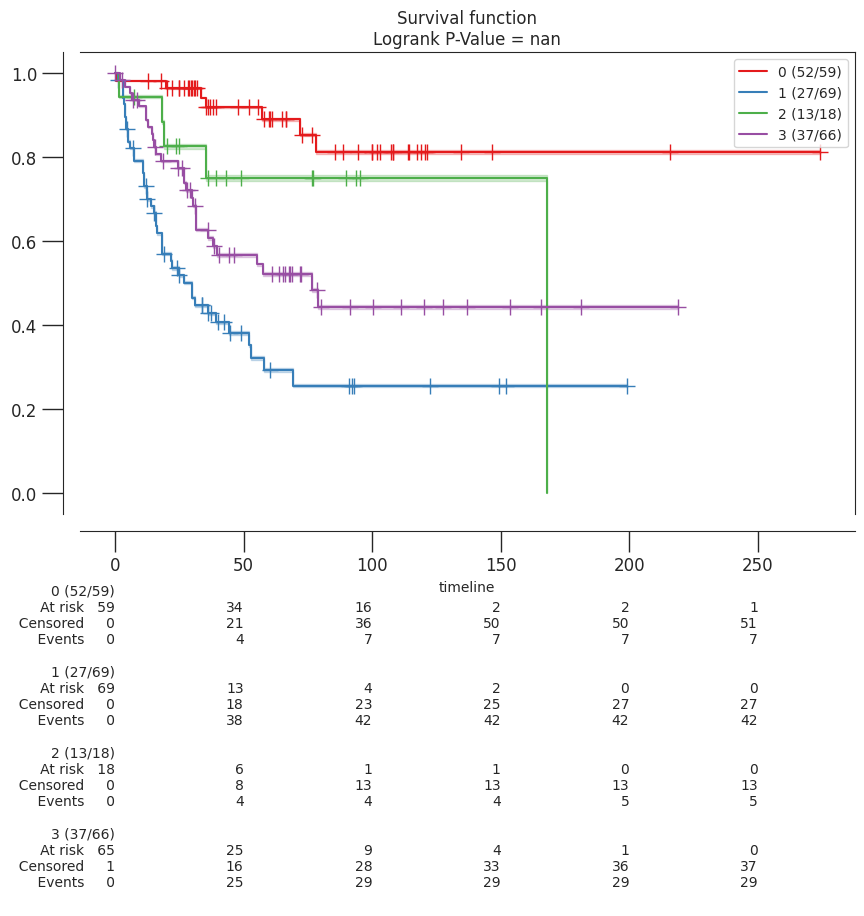

In [125]:
results = km.fit(km_df["OS"],km_df["OS_FLAG"],km_df["Clusters"])
km.plot(results)


In [134]:
tmp = scaled_scores2.merge(cluster_series,left_index=True,right_index=True)
t = tmp.groupby("Clusters").mean().idxmax()
rep_dict = {}
for ind, val in t.items():
  rep_dict[int(val)] = ind
km_df["Clusters"] = km_df["Clusters"].replace(rep_dict)

Не уверен, что просто усреднить скоры и просто назначить тип по наибольшему значению - это правильно, но вроде получается нормально.

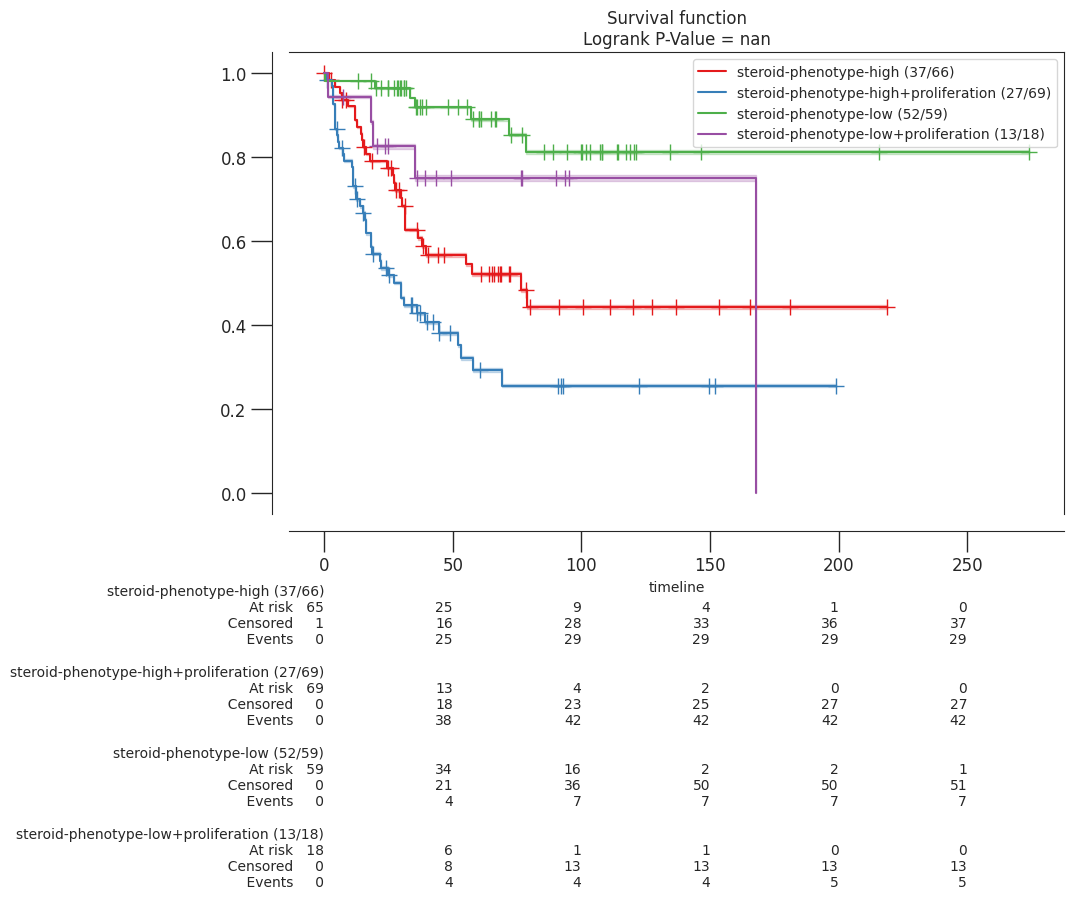

In [135]:
results = km.fit(km_df["OS"],km_df["OS_FLAG"],km_df["Clusters"])
km.plot(results)

Подтип steroid phenotype low связан с лучшим прогнозом, а подтип steroid phenotype hight + proliferation - с худшим